# Common raster operations

- Clipping
- Masking
- Rasterize: Vector to raster
- Vectorize: Raster to Vector
- Creating a raster mosaic: Merging
- Estimate bounds of the raster
- Resample: upscaling / downscaling
- Interpolating missing data


## Clipping raster

One of the common operations when working with raster data is to clip a given raster `Dataset` by another layer. This process allows you to crop the data in a way that only the cells that are e.g. within a given Polygon are selected for further analysis. In the following, we will learn how to do this by using the `.rio.clip()` method that comes with the `rioxarray` library. Let's start by reading the `elevation` dataset that we used earlier in Chapter 7.2:

In [5]:
import xarray as xr
import matplotlib.pyplot as plt

fp = "data/temp/kilimanjaro_dataset.nc"

data = xr.open_dataset(fp, decode_coords="all")
data

<xarray.Dataset> Size: 156MB
Dimensions:          (y: 3601, x: 3601)
Coordinates:
  * x                (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0
  * y                (y) float64 29kB -2.0 -2.0 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref      int32 4B ...
Data variables:
    elevation        (y, x) float64 104MB ...
    relative_height  (y, x) float32 52MB ...

Let's also plot the data to see how our values look on a map:

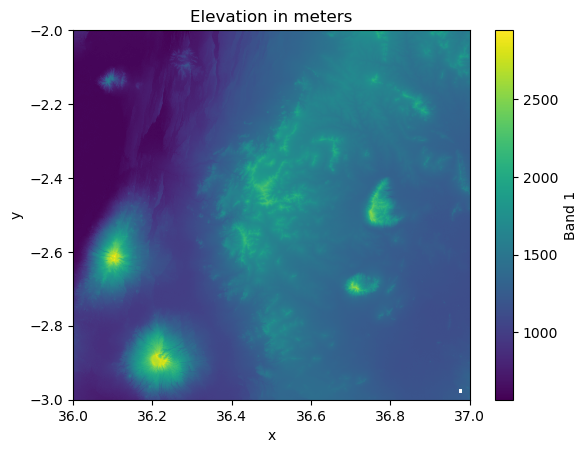

In [7]:
data["elevation"].plot()
plt.title("Elevation in meters");

***Figure 7.7** Elevation of the landscape in North-Eastern Tanzania.*

To be able to clip this `xarray.Dataset`, we first need to create a `geopandas.GeoDataFrame` that contains the geometry that we want to use as our clipping features. In our case, we want to create a simple bounding box that defines the area which we want to keep from the raster. To create the `GeoDataFrame`, we can specify the corner coordinates of our bounding box and utilize the `box` function of `shapely` library which can conveniently create us the geometry (as introduced in Chapter 6.1):

In [13]:
import geopandas as gpd
from shapely.geometry import box

# Bounding box coordinates
minx = 36.1
miny = -3
maxx = 36.3
maxy = -2.77

# Create a GeoDataFrame that will be used to clip the raster
bbox_geometry = box(minx, miny, maxx, maxy)
clipping_gdf = gpd.GeoDataFrame(geometry=[bbox_geometry], crs="epsg:4326")

# Explore the extent on a map
clipping_gdf.explore()

***Figure 7.8** Our area of interest around the Mt Kitumbene in Tanzania which will be used to clip the raster dataset.*

Now after we have created the `GeoDataFrame` we can use it to clip the `xarray.Dataset`. To do this, we use the `.rio.clip()` method which wants as input the `geometries` that will be used for clipping the raster data. We can pass the `gpd.GeoSeries` as an input for this (i.e. the `geometry` column of our `GeoDataFrame`) and we also specify the `crs` to be the same as in out input raster data. It is important that the coordinate reference system of both layers are the same whenever doing GIS operations between multiple layers. Thus, we use a simple `assert` to check the match before doing the clipping:

In [19]:
# Check that the CRS matches between layers (only continues if True)
assert clipping_gdf.crs == data.elevation.rio.crs

# Clip the raster
kitumbene = data.rio.clip(geometries=clipping_gdf.geometry, crs=data.elevation.rio.crs)

Perfect! Now we have succesfully clipped the raster with our bounding box. Let's make a map out of our results to see how our data looks like:

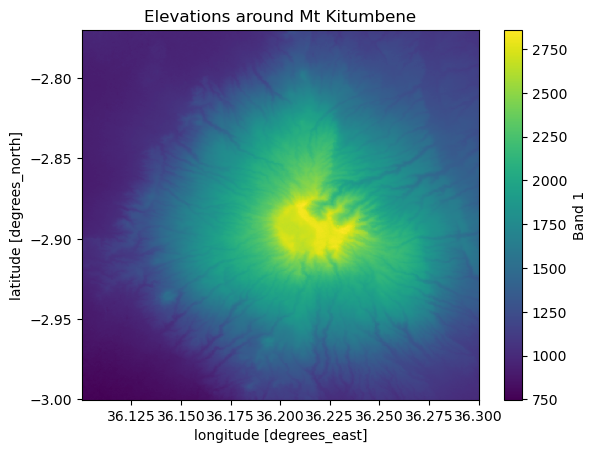

In [22]:
kitumbene["elevation"].plot()
plt.title("Elevations around Mt Kitumbene");

***Figure 7.9** Elevations in the area that was clipped based on a polygon.*

After clipping, it is possible to continue working with the clipped `Dataset` and e.g. find the mean elevation for this area around the Mt Kitumbene. Notice that the operations clipped all the variables in our `Dataset` simultaneously. We can extract basic statistics from `elevation` and inspect the relative height in this area as follows:

In [30]:
# Mean elevation
kitumbene["elevation"].mean().item()

1467.7473111245304

In [31]:
# Update the relative height considering the minimum elevation on this area
kitumbene["relative_height"] = kitumbene["elevation"] - kitumbene["elevation"].min()

# Mean of the relative height
kitumbene["relative_height"].max().item()

2109.0

We can see that the mean elevation in this area is approximately 1470 meters while the maximum relative height is ~2100 meters. We needed to recalculate the relative height because the baseline minimum elevation in the landscape changed significantly after the clipping operation.

## Masking a raster

Another commonly used approach when working with raster data is to mask the data based on certain criteria or using another geographical layer as a mask. One common reasons for doing this is for example to exclude water bodies (e.g. lakes or oceans) from the terrain when doing specific analyses. In the following, we will continue working with the same elevation data and mask out the lakes from our raster dataset that exist in our study area. 

Let's start by downloading data from OpenStreetMap (OSM) about existing lakes in our study area. To do this, we first extract the bounds of our raster `Dataset` and then use `osmnx` library to fetch all OSM elements that have been tagged with key `"water"` and `"lake"` (read more about `osmnx` from Chapter 9.1):

/Users/tenkanh2/micromamba/envs/python-gis-book/lib/python3.12/site-packages/osmnx/features.py:678: PerformanceWarning: indexing past lexsort depth may impact performance.
  gdf.loc[:, "geometry"] = gdf["geometry"].make_valid()


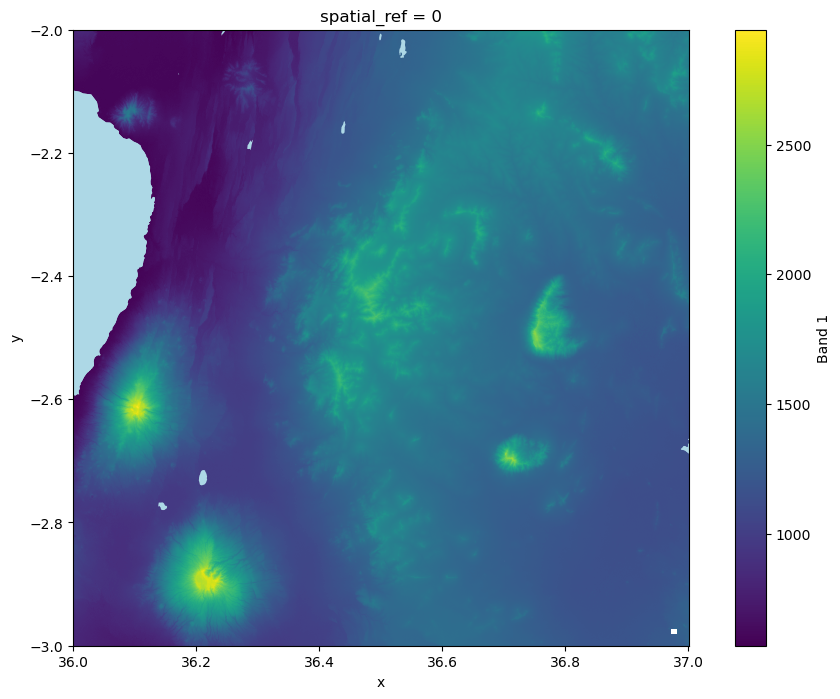

In [45]:
import osmnx as ox

# Extract the bounding box based on the extent of the raster
data_bounds_geom = box(*data["elevation"].rio.bounds())

# Retrieve lakes from the given area
lakes = ox.features_from_polygon(data_bounds_geom, tags={"water": ["lake"]})

# Plot the raster and lakes on top of each other
fig, ax = plt.subplots(figsize=(12, 8))
data["elevation"].plot(ax=ax)
lakes.plot(ax=ax, color="lightblue");

***Figure 7.10** Existing lakes that are present in our study area.*

As we can see from the Figure 7.10, there is one large lake and multiple smaller ones in our study that we might not want to be taken into account when analyzing the terrain. Luckily, we can easily mask these areas out of our `Dataset` by using `rioxarray`. To do this, we can use the same `.rio.clip()` method which we used in the previous example. However, in this case, we do not want to totally remove those cells from our `Dataset` but only mask them out, so that the values on those areas are replaced with NaN values. By using parameters `drop=False` and `invert=True`, the cells that are intersecting with the lake geometries will be masked with NaNs: 

In [48]:
masked_data = data.rio.clip(geometries=lakes.geometry, 
                            drop=False,
                            invert=True,
                            crs=data.elevation.rio.crs, 
                           )

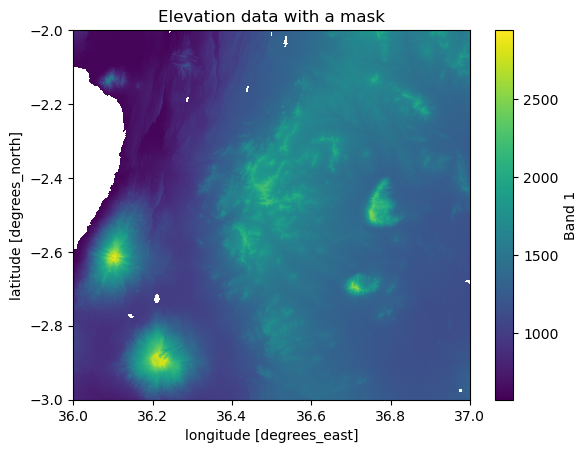

In [50]:
masked_data["elevation"].plot()
plt.title("Elevation data with a mask");

***Figure 7.11** A Dataset where the lakes have been masked out (shown with white color).*

As a result, we now have a new `Dataset` where the elevation values overlapping with the lakes have been converted to NaNs. We can now compare whether e.g. the mean land surface elevation differs from the original one where the lakes were still included:

In [52]:
print("Mean elevation with lakes:", data["elevation"].mean().round().item())
print("Mean elevation without lakes:", masked_data["elevation"].mean().round().item())

Mean elevation with lakes: 1258.0
Mean elevation without lakes: 1287.0


Based on this comparison, we can see that masking out the lakes increases the mean elevation in the area by approximately 30 meters. In a similar manner, you can mask any `rioxarray.Dataset` with given mask features that you want to remove from the analysis. 

## Creating a raster mosaic - merging raster datasets

Quite often you need to merge multiple raster files together and create a `raster mosaic`. This can be done easily with the `merge_datasets()` -function in `rioxarray`.
Here, we will create a mosaic based on DEM files (altogether 4 files) covering Kilimanjaro region in Tanzania. First we will read elevation data from a S3 bucket for Kilimanjaro region in Africa.

In [1]:
import xarray as xr
import os
import rioxarray as rxr
from rioxarray.merge import merge_datasets

# S3 bucket containing the data
bucket = "https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/PythonGIS"

# Generate urls for the elevation files
urls = [
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S03E036_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S03E037_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S04E036_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S04E037_dem.tif"),
]

# Read the files
datasets = [
    xr.open_dataset(url, engine="rasterio").squeeze("band", drop=True) for url in urls
]

Investigate how our data looks like:

In [2]:
datasets[0]

<xarray.Dataset>
Dimensions:      (x: 3601, y: 3601)
Coordinates:
  * x            (x) float64 36.0 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 -2.0 -2.0 -2.001 -2.001 ... -2.999 -2.999 -3.0 -3.0
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

Visualize the tiles to see how they look like separately:

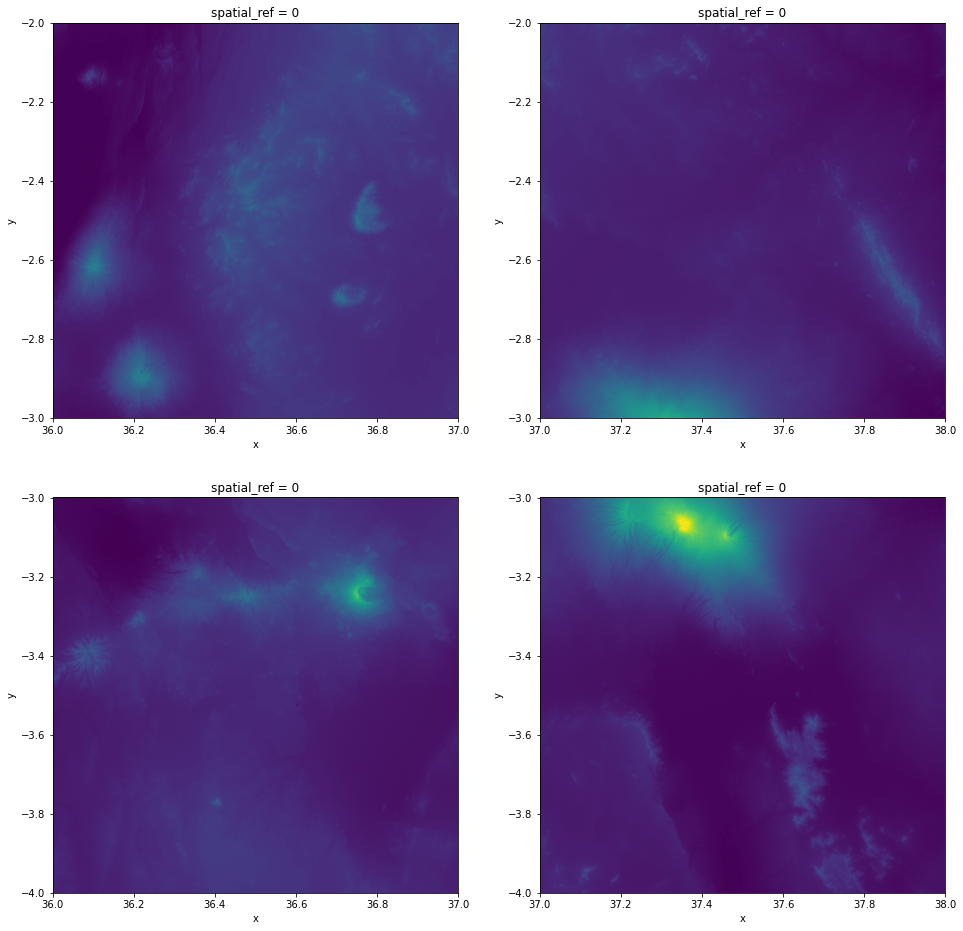

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Plot the tiles to see how they look separately
datasets[0]["band_data"].plot(ax=axes[0][0], vmax=5900, add_colorbar=False)
datasets[1]["band_data"].plot(ax=axes[0][1], vmax=5900, add_colorbar=False)
datasets[2]["band_data"].plot(ax=axes[1][0], vmax=5900, add_colorbar=False)
datasets[3]["band_data"].plot(ax=axes[1][1], vmax=5900, add_colorbar=False)

As we can see we have multiple separate raster files that are actually located next to each other. Hence, we want to put them together into a single raster file that can by done by creating a raster mosaic.
Now we can create a raster mosaic by merging these datasets with `merge_datasets()` function:

In [4]:
# Create a mosaic out of the tiles
mosaic = merge_datasets(datasets)

Rename the data variable to more intuitive one:

In [5]:
# Add a more intuitive name for the data variable
mosaic = mosaic.rename({"band_data": "elevation"})

Plot the end result where the tiles have been merged:

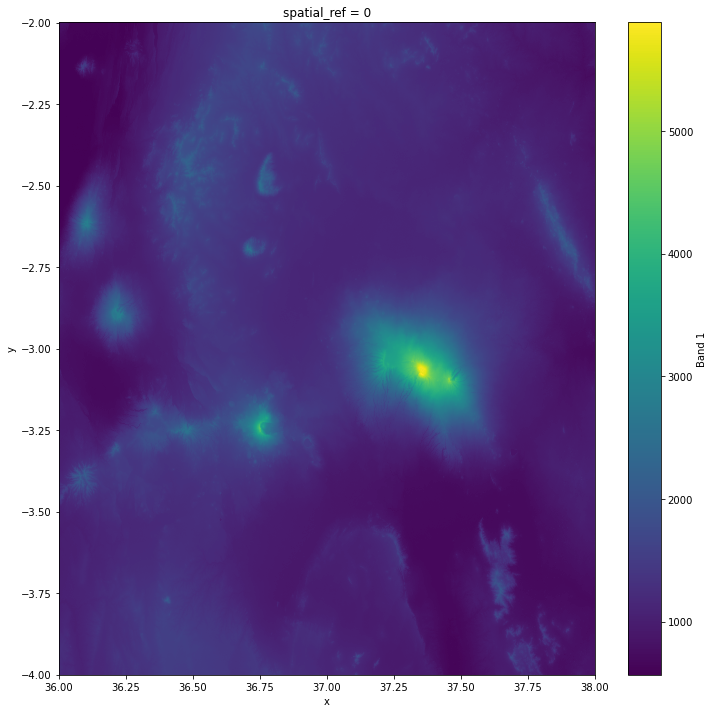

In [6]:
# Plot the mosaic
mosaic["elevation"].plot(figsize=(12, 12))